**<h2>ORIE 5530: NYC Citibike Project</h2>**

This project computes the transition probabilities and stationary distributions for three stations in the July 2022 NYC Citibike dataset. Before computation, the dataset is preprocessed to reduce the noise and eliminate irrelevant information to yield more accurate results. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(linewidth=300)
pd.set_option('display.max_rows', 500)

df = pd.read_csv('202207-citbike-tripdata.csv', low_memory=False)
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,C09E4093905089BD,classic_bike,2022-07-23 11:34:57,2022-07-23 11:45:08,Melrose St & Broadway,4801.04,Myrtle Ave & Grove St,4816.05,40.697481,-73.935877,40.699050,-73.915160,member
1,374630DB5822C392,electric_bike,2022-07-29 18:19:08,2022-07-29 18:26:50,E 68 St & 3 Ave,6896.16,E 85 St & York Ave,7146.04,40.767128,-73.962246,40.775369,-73.948034,member
2,4F73CA25880A1215,electric_bike,2022-07-16 16:30:58,2022-07-16 17:39:18,W 37 St & 10 Ave,6611.02,Knickerbocker Ave & Cooper St,4582.05,40.756604,-73.997901,40.690810,-73.904480,member
3,ECD6EE19C0CC1D31,electric_bike,2022-07-17 17:35:57,2022-07-17 18:03:36,W 37 St & 10 Ave,6611.02,6 Ave & Broome St,5610.09,40.756604,-73.997901,40.724310,-74.004730,member
4,44D0987673B9997D,classic_bike,2022-07-11 07:56:29,2022-07-11 07:59:15,E 68 St & 3 Ave,6896.16,E 66 St & Madison Ave,6969.08,40.767128,-73.962246,40.768009,-73.968453,member


For each ride, the dataset provides a ride ID and type, start time and date, end time and date, start and end station IDs and Names, station lat/long, and the user type. As the dataset is large (3,497,390 rows), unecessary columns are dropped to provide focus on the relevant information. In this case, 'start station ID', 'end station ID', 'start lat/long' and 'end lat/long' were dropped because the 'station name' is sufficient in identifying which stations were are referring to as all stations have different names.

In [2]:
#drop unecessary columns
df = df.drop(columns=['start_station_id','end_station_id','start_lat','start_lng','end_lat','end_lng'])
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,member_casual
0,C09E4093905089BD,classic_bike,2022-07-23 11:34:57,2022-07-23 11:45:08,Melrose St & Broadway,Myrtle Ave & Grove St,member
1,374630DB5822C392,electric_bike,2022-07-29 18:19:08,2022-07-29 18:26:50,E 68 St & 3 Ave,E 85 St & York Ave,member
2,4F73CA25880A1215,electric_bike,2022-07-16 16:30:58,2022-07-16 17:39:18,W 37 St & 10 Ave,Knickerbocker Ave & Cooper St,member
3,ECD6EE19C0CC1D31,electric_bike,2022-07-17 17:35:57,2022-07-17 18:03:36,W 37 St & 10 Ave,6 Ave & Broome St,member
4,44D0987673B9997D,classic_bike,2022-07-11 07:56:29,2022-07-11 07:59:15,E 68 St & 3 Ave,E 66 St & Madison Ave,member


All data were stored as objects, which take up a lot of memory space in comparison to category data types. Having limited unique values for 'rideable type', 'start station name', 'end station name', and 'member casual', these columns are converted into category data types in the following code. As this project works on only one month of data, memory usage is not a problem and this step is not necessary. However, this is essential when working on year's dataset. 

In [3]:
pd.DataFrame.from_records([(col, df[col].nunique(), df[col].dtype, df[col].memory_usage(deep=True) )  for col in df.columns],
  columns=['Column Name', 'Unique', 'Data Type','Memory Usage'])


,Column Name,Unique,Data Type,Memory Usage
0,ride_id,3497390,object,255309598
1,rideable_type,3,object,242110059
2,started_at,1673509,object,265801768
3,ended_at,1676484,object,265801768
4,start_station_name,1583,object,269498254
5,end_station_name,1623,object,269089059
6,member_casual,2,object,220335698


In [4]:
cols = ['start_station_name', 'end_station_name', 'rideable_type', 'member_casual']
for col in cols:
    df[col] = df[col].astype('category')

# convert dtype to datetime
df['started_at'] = pd.to_datetime(df['started_at']) 
df['ended_at'] = pd.to_datetime(df['ended_at'])

pd.DataFrame.from_records([(col, df[col].nunique(), df[col].dtype, df[col].memory_usage(deep=True) )  for col in df.columns],
  columns=['Column Name', 'Unique', 'Data Type','Memory Usage'])

,Column Name,Unique,Data Type,Memory Usage
0,ride_id,3497390,object,255309598
1,rideable_type,3,category,3497833
2,started_at,1673509,datetime64[ns],27979248
3,ended_at,1676484,datetime64[ns],27979248
4,start_station_name,1583,category,7184208
5,end_station_name,1623,category,7187213
6,member_casual,2,category,3497752


With only the time the ride starts at and ended at, to calculate the trip duration, we subtract the time the ride ends by the time it starts. Trip durations ranged from -1 to 30 days, which were unrealistic. These anomalies were eliminated leaving rides ranging from 0 to 3 hours. The result is 3,484,671 rides.

In [5]:
df['trip_duration'] = df['ended_at'] - df['started_at'] #calc trip duration
print(df.shape)
df.sort_values(by='trip_duration')

(3497390, 8)


,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,member_casual,trip_duration
1220406,6CDCAFB0512D5C61,electric_bike,2022-07-04 14:13:19,2022-07-04 13:57:50,E 44 St & 2 Ave,E 44 St & 2 Ave,member,-1 days +23:44:31
1227791,61535818207DB39E,classic_bike,2022-07-07 09:05:41,2022-07-07 08:53:34,Central Park West & W 76 St,Central Park West & W 76 St,member,-1 days +23:47:53
1722273,C5B6A122A6EAA7CC,electric_bike,2022-07-15 10:47:49,2022-07-15 10:39:33,Walker St & Baxter St,Walker St & Baxter St,member,-1 days +23:51:44
1505116,192EE0153F7D48B2,electric_bike,2022-07-04 14:00:46,2022-07-04 13:55:28,Clinton Ave & Myrtle Ave,Clinton Ave & Myrtle Ave,member,-1 days +23:54:42
606534,8E7976D3768353C0,classic_bike,2022-07-04 14:01:06,2022-07-04 13:58:35,E 97 St & 3 Ave,E 97 St & 3 Ave,member,-1 days +23:57:29
...,...,...,...,...,...,...,...,...
803423,8044B7D41EB3FC48,docked_bike,2022-07-10 11:35:36,2022-07-27 01:21:41,S 4 St & Rodney St,W 41 St & 8 Ave,casual,16 days 13:46:05
1529256,031E4496288F55BB,docked_bike,2022-07-06 11:55:22,2022-07-23 14:10:38,3 Ave & E 112 St,Adam Clayton Powell Blvd & W 130 St,casual,17 days 02:15:16
976978,74835B99B1B7D1CD,docked_bike,2022-07-07 13:59:36,2022-08-02 05:34:55,Fulton St & Broadway,W 42 St & 6 Ave,casual,25 days 15:35:19
3391655,C429B9C2F43EF043,docked_bike,2022-07-03 16:22:58,2022-08-01 10:19:43,E 4 St & 2 Ave,Irving Ave & Jefferson St,casual,28 days 17:56:45


In [6]:
#removing rows that are greater than 3 hours and less than 0
df_new = df[df['trip_duration'].dt.seconds <= 10800] 
df_new = df_new[df_new['trip_duration'].dt.days <= 0]
df_new.sort_values(by='trip_duration')

,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,member_casual,trip_duration
1452451,1DD39431E7E999A4,classic_bike,2022-07-17 19:36:32,2022-07-17 19:36:32,W 56 St & 10 Ave,W 56 St & 10 Ave,member,0 days 00:00:00
88556,EC3EE68ACF27C9A1,classic_bike,2022-07-20 21:55:20,2022-07-20 21:55:20,E 91 St & 2 Ave,E 91 St & 2 Ave,member,0 days 00:00:00
1967814,0DB737CF08C71406,classic_bike,2022-07-08 19:24:57,2022-07-08 19:24:57,1 Ave & E 78 St,1 Ave & E 78 St,member,0 days 00:00:00
1740639,146089C055FB9FF6,classic_bike,2022-07-05 12:28:54,2022-07-05 12:28:54,6 Ave & Broome St,6 Ave & Broome St,member,0 days 00:00:00
606237,E3E7A74D5270F4AC,classic_bike,2022-07-05 18:15:05,2022-07-05 18:15:05,Park Ave & E 124 St,Park Ave & E 124 St,member,0 days 00:00:00
...,...,...,...,...,...,...,...,...
1526776,386A8F9232CACCEB,classic_bike,2022-07-10 11:27:37,2022-07-10 14:27:36,Cleveland Pl & Spring St,Grand St & Elizabeth St,casual,0 days 02:59:59
606365,F2BF0E31B7D982CF,classic_bike,2022-07-04 19:39:10,2022-07-04 22:39:09,36 Ave & 10 St,36 Ave & 10 St,casual,0 days 02:59:59
2871502,25462A580CF8251D,classic_bike,2022-07-15 13:38:55,2022-07-15 16:38:55,W 34 St & 11 Ave,West St & Liberty St,casual,0 days 03:00:00
2499543,6FD7A2900D699E56,docked_bike,2022-07-09 19:14:01,2022-07-09 22:14:01,E 16 St & 5 Ave,Carmine St & 6 Ave,casual,0 days 03:00:00


**<h4>Warm-up Questions</h4>**

To gain a better understanding of the dataset, a series of analysis were completed.

<h4>1. Histogram</h4>

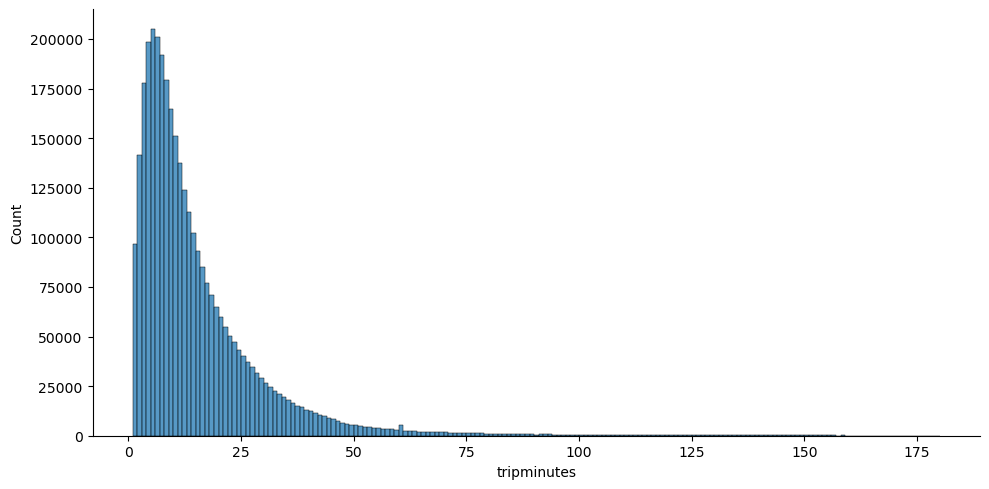

In [7]:
#1 - histogram of ride durations 
pd.options.mode.chained_assignment = None  # default='warn'

df_new['tripminutes'] = df_new.trip_duration.dt.seconds/60
sns.displot(data=df_new,x="tripminutes", bins=range(1,181), aspect=10/5)


<h4>2. Expected Ride Duration, Variance, Probability</h4>

In [8]:
#2 
# df_new.describe().round(2)
print('Expected Ride Duration:', df_new.tripminutes.mean()) 
print('Empirical Variance:', df_new.tripminutes.var()) 


# Probability ride duration > 20 mins
p_20mins = sum(df_new['tripminutes'] > 20)/len(df_new)
print('P(tripminutes > 20):', p_20mins)


Expected Ride Duration: 14.993813519267052
Empirical Variance: 232.8328785622765
P(tripminutes > 20): 0.2327215395657151


<h4>3. Probability Ride Duration is greater than 20 minutes, Given user is a Member</h4>

In [9]:
#3 Probability ride duration > 20 given member
df_mem = df_new[df_new['member_casual'] == 'member']
cond = sum(df_mem['tripminutes'] > 20)/len(df_mem)
print('P(tripminutes > 20 | member): ', cond)

P(tripminutes > 20 | member):  0.18609139832749863


<h4>4. Probability user is a Member, given Ride Duration is greater than 25 minutes</h4>

In [10]:
#4 Probability member given ride duration > 25
df_25 = df_new[df_new['tripminutes'] > 25]
cond = sum(df_25['member_casual'] == 'member')/len(df_25)
print('P(member | tripminutes > 25): ', cond)

P(member | tripminutes > 25):  0.5839272451304628


<h4>5. Expected Ride Duration for Electric and Classic Bikes</h4>

In [11]:
#5 Expected ride duration of electric, classic
df_electric = df_new[df_new['rideable_type'] == 'electric_bike']
df_classic = df_new[df_new['rideable_type'] == 'classic_bike']

print('Expected Ride Duration (Electric):', df_electric['tripminutes'].mean())
print('Expected Ride Duration (Classic):', df_classic['tripminutes'].mean())

Expected Ride Duration (Electric): 15.170728448189486
Expected Ride Duration (Classic): 14.731529263276226


<h4>6. Probability Bike is Electric/Classic, given Ride Duration is less than 10 minutes</h4>

In [12]:
#6 Ride Duration < 10, Probability electric, probability classic
df_10 = df_new[df_new['tripminutes'] < 10]
electric = sum(df_10['rideable_type'] == 'electric_bike')/len(df_10)
classic = sum(df_10['rideable_type'] == 'classic_bike')/len(df_10)

print('P(electric | tripminutes <10):', electric)
print('P(classic | tripminutes <10):', classic)

P(electric | tripminutes <10): 0.23379223076630087
P(classic | tripminutes <10): 0.7634756659010651


P(electric | tripminutes <10) + P(classic | tripminutes <10) does not equal 1. This is because there are three unique types of bikes: classic, electric, and docked. P(docked| tripminutes <10) = 1 - (P(electric | tripminutes <10) + P(classic | tripminutes <10))

In [13]:
print('Sum of probabilities', electric+classic)
df_new['rideable_type'].unique()

Sum of probabilities 0.9972678966673659


['classic_bike', 'electric_bike', 'docked_bike']
Categories (3, object): ['classic_bike', 'docked_bike', 'electric_bike']

**<h4>Project</h4>**

To begin with the project, three stations were random selected after grouping the rides to have a general idea of which stations are most popular. The following stations were selected and their respective capacities found on Google Maps:
* Broadway & W 25 St (67 bikes)
* Great Jones St (19 bikes)
* 9 Ave & W 22 St (58 bikes)


In [14]:
#selecting stations
start_grouped = df_new.groupby(['start_station_name'])['start_station_name'].size().sort_values(ascending=False)
print(start_grouped)

start_station_name
West St & Chambers St       15830
W 21 St & 6 Ave             13492
Broadway & W 58 St          12744
Broadway & E 14 St          12645
6 Ave & W 33 St             12596
                            ...  
Morgan WH station              17
Morgan Loading Docks           15
Nassau St\t& Duffield St       14
54 St & 37 Ave                 10
Lab - NYC                       2
Name: start_station_name, Length: 1583, dtype: int64


All rides that didn't contain the three stations as either its start station or end station were removed from the dataset.

In [15]:
df_station = df_new.loc[(df_new.start_station_name == 'Broadway & W 25 St')|\
    (df_new.start_station_name == 'Great Jones St')|(df_new.start_station_name == '9 Ave & W 22 St')|\
        (df_new.end_station_name == 'Broadway & W 25 St')| (df_new.end_station_name == 'Great Jones St')|\
            (df_new.end_station_name == '9 Ave & W 22 St')]

df_station

,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,member_casual,trip_duration,tripminutes
10236,155D0D1BBC944742,classic_bike,2022-07-09 17:27:19,2022-07-09 17:57:26,E 68 St & 3 Ave,Great Jones St,member,0 days 00:30:07,30.116667
10238,D2A5A41003BF2B38,classic_bike,2022-07-19 17:36:06,2022-07-19 17:57:02,W 34 St & 11 Ave,Great Jones St,member,0 days 00:20:56,20.933333
10301,12FFE79CF0206F63,classic_bike,2022-07-15 13:48:26,2022-07-15 14:07:55,FDR Drive & E 35 St,Great Jones St,member,0 days 00:19:29,19.483333
10303,ACBF3C853263D449,electric_bike,2022-07-19 19:20:40,2022-07-19 19:25:56,E 20 St & 2 Ave,Great Jones St,member,0 days 00:05:16,5.266667
10315,9355209F0E352E34,classic_bike,2022-07-16 19:47:33,2022-07-16 20:03:44,W 37 St & 10 Ave,Great Jones St,member,0 days 00:16:11,16.183333
...,...,...,...,...,...,...,...,...,...
3493668,A858C082C59400C0,classic_bike,2022-07-19 08:41:17,2022-07-19 08:58:15,9 Ave & W 22 St,Grand Army Plaza & Central Park S,member,0 days 00:16:58,16.966667
3493669,31442C0620C8CAF6,classic_bike,2022-07-08 08:44:36,2022-07-08 09:01:25,9 Ave & W 22 St,Grand Army Plaza & Central Park S,member,0 days 00:16:49,16.816667
3493702,B10956701CFC7DC6,electric_bike,2022-07-18 05:23:40,2022-07-18 05:35:56,9 Ave & W 22 St,Grand Army Plaza & Central Park S,member,0 days 00:12:16,12.266667
3493799,D71B1DEE024A47DD,electric_bike,2022-07-27 08:40:01,2022-07-27 08:59:27,9 Ave & W 22 St,Grand Army Plaza & Central Park S,member,0 days 00:19:26,19.433333


For this project, weekends were removed from the dataset as the movements differ between weekdays and weekends. 

In [16]:
# removing weekends (weekday >= 5 )
df_station = df_station[df_station.started_at.dt.dayofweek < 5]

For similar reasons, the dataset was split between morning and evening as the patterns differ based on the time. The morning block is between 7am to 12pm, whilst the evening block is between 5pm to 10pm.

In [17]:
#split morning and evening
time = df_station.started_at.dt.hour
time.value_counts().sort_values(ascending=False)

18    3833
17    3646
19    2641
16    2547
9     2169
8     2167
15    2108
14    2005
13    1883
12    1858
20    1808
11    1586
10    1527
7     1198
21    1112
22     887
23     633
6      578
0      253
5      197
1      126
2       72
3       46
4       32
Name: started_at, dtype: int64

In [18]:
morning_start_time = 7
morning_end_time = 12
evening_start_time = 17
evening_end_time = 22

df_morning = df_station[(df_station.started_at.dt.hour >= morning_start_time) & (df_station.started_at.dt.hour < morning_end_time)]
df_evening = df_station[(df_station.started_at.dt.hour >= evening_start_time) & (df_station.started_at.dt.hour < evening_end_time)]

df_morning

,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,member_casual,trip_duration,tripminutes
10316,ADEC6864444B9FF3,classic_bike,2022-07-27 08:50:20,2022-07-27 09:17:42,W 34 St & 11 Ave,Great Jones St,member,0 days 00:27:22,27.366667
10431,20A167BFFEB85DE5,classic_bike,2022-07-27 09:02:01,2022-07-27 09:23:36,W 22 St & 10 Ave,Great Jones St,member,0 days 00:21:35,21.583333
10466,8FE9CDD3C2311975,classic_bike,2022-07-08 09:58:24,2022-07-08 09:59:50,Washington Pl & Broadway,Great Jones St,member,0 days 00:01:26,1.433333
10477,4F79A05A5BA11C47,classic_bike,2022-07-25 10:03:49,2022-07-25 10:12:31,Clinton St & Grand St,Great Jones St,member,0 days 00:08:42,8.700000
10482,7C66EA9BBD75D1EC,classic_bike,2022-07-22 07:01:47,2022-07-22 07:12:55,Clinton St & Cherry St,Great Jones St,member,0 days 00:11:08,11.133333
...,...,...,...,...,...,...,...,...,...
3493667,9069768807DBCD07,classic_bike,2022-07-18 08:38:07,2022-07-18 08:55:08,9 Ave & W 22 St,Grand Army Plaza & Central Park S,member,0 days 00:17:01,17.016667
3493668,A858C082C59400C0,classic_bike,2022-07-19 08:41:17,2022-07-19 08:58:15,9 Ave & W 22 St,Grand Army Plaza & Central Park S,member,0 days 00:16:58,16.966667
3493669,31442C0620C8CAF6,classic_bike,2022-07-08 08:44:36,2022-07-08 09:01:25,9 Ave & W 22 St,Grand Army Plaza & Central Park S,member,0 days 00:16:49,16.816667
3493799,D71B1DEE024A47DD,electric_bike,2022-07-27 08:40:01,2022-07-27 08:59:27,9 Ave & W 22 St,Grand Army Plaza & Central Park S,member,0 days 00:19:26,19.433333


**<h4>9 Ave & W 22 St - 58 Capacity</h4>**

<h4>Morning</h4>

In [19]:
df_morning = df_morning.drop(columns=['rideable_type','member_casual','trip_duration','tripminutes'])
df_morning = df_morning.sort_values(by='started_at')

In [20]:
df_9ave_morning = df_morning.loc[(df_morning.start_station_name == '9 Ave & W 22 St')|(df_morning.end_station_name == '9 Ave & W 22 St')]
df_9ave_evening = df_evening.loc[(df_evening.start_station_name == '9 Ave & W 22 St')|(df_evening.end_station_name == '9 Ave & W 22 St')]

print("Amount of rides entering or exiting in the morning in July 2022:", df_9ave_morning.index.size)
print("Amount of rides entering or exiting in the evening in July 2022:", df_9ave_evening.index.size)

Amount of rides entering or exiting in the morning in July 2022: 2716
Amount of rides entering or exiting in the evening in July 2022: 4798


In [21]:
def bike_in_9ave(row):
    if row['start_station_name'] != "9 Ave & W 22 St" and row['end_station_name'] == "9 Ave & W 22 St":
        x = 1
    else:
        x = 0
    return x

def bike_out_9ave(row):
    if row['start_station_name'] == "9 Ave & W 22 St" and row['end_station_name'] != "9 Ave & W 22 St":
        x = -1
    else:
        x = 0
    return x

In [22]:
df_9ave_morning['In'] = df_9ave_morning.apply(bike_in_9ave, axis=1)
df_9ave_morning['Out'] = df_9ave_morning.apply(bike_out_9ave, axis=1)

df_9ave_in = df_9ave_morning.groupby(pd.Grouper(key="started_at", freq='5T'))['In'].sum().to_frame()
df_9ave_out = df_9ave_morning.groupby(pd.Grouper(key="ended_at", freq='5T'))['Out'].sum().to_frame()

merge_9ave = pd.concat([df_9ave_in, df_9ave_out], axis=1).fillna(0)
nineave_morning = merge_9ave.reset_index().rename({'index': 'Time'}, axis=1)

nineave_morning = nineave_morning[nineave_morning.Time.dt.dayofweek < 5]
nineave_morning = nineave_morning[(nineave_morning.Time.dt.hour >= morning_start_time) & (nineave_morning.Time.dt.hour < morning_end_time)]

nineave_morning['Net Flow'] = nineave_morning['In'] + nineave_morning['Out']
nineave_morning['Net Flow'] = nineave_morning['Net Flow'].apply(int)
nineave_morning = nineave_morning.reset_index().drop(columns = 'index')
nineave_morning

,Time,In,Out,Net Flow
0,2022-07-01 07:05:00,0.0,0.0,0
1,2022-07-01 07:10:00,0.0,0.0,0
2,2022-07-01 07:15:00,0.0,0.0,0
3,2022-07-01 07:20:00,0.0,-2.0,-2
4,2022-07-01 07:25:00,0.0,-1.0,-1
...,...,...,...,...
1254,2022-07-29 11:35:00,0.0,-1.0,-1
1255,2022-07-29 11:40:00,1.0,-3.0,-2
1256,2022-07-29 11:45:00,3.0,-3.0,0
1257,2022-07-29 11:50:00,2.0,-2.0,0


In [23]:
nineave_morning_probabilities = (nineave_morning.groupby(['Net Flow'])['Net Flow'].count()/nineave_morning.groupby(['Net Flow'])['Net Flow'].count().sum()).to_frame().rename({'Net Flow': 'Probability'}, axis=1).reset_index()
nineave_morning_probabilities

,Net Flow,Probability
0,-7,0.001589
1,-6,0.004766
2,-5,0.012708
3,-4,0.033360
4,-3,0.063542
5,-2,0.114376
6,-1,0.225576
7,0,0.328038
8,1,0.142971
9,2,0.054011


<h4>Evening

In [25]:
df_9ave_evening['In'] = df_9ave_evening.apply(bike_in_9ave, axis=1)
df_9ave_evening['Out'] = df_9ave_evening.apply(bike_out_9ave, axis=1)

dfe_9ave_in = df_9ave_evening.groupby(pd.Grouper(key="started_at", freq='5T'))['In'].sum().to_frame()
dfe_9ave_out = df_9ave_evening.groupby(pd.Grouper(key="ended_at", freq='5T'))['Out'].sum().to_frame()

merge_9ave_evening = pd.concat([dfe_9ave_in, dfe_9ave_out], axis=1).fillna(0)
nineave_evening = merge_9ave_evening.reset_index().rename({'index': 'Time'}, axis=1)

nineave_evening = nineave_evening[nineave_evening.Time.dt.dayofweek < 5]
nineave_evening = nineave_evening[(nineave_evening.Time.dt.hour >= evening_start_time) & (nineave_evening.Time.dt.hour < evening_end_time)]

nineave_evening['Net Flow'] = nineave_evening['In'] + nineave_evening['Out']
nineave_evening['Net Flow'] = nineave_evening['Net Flow'].apply(int)
nineave_evening = nineave_evening.reset_index().drop(columns = 'index')
nineave_evening


,Time,In,Out,Net Flow
0,2022-07-01 17:00:00,0.0,-1,-1
1,2022-07-01 17:05:00,1.0,-1,0
2,2022-07-01 17:10:00,4.0,-2,2
3,2022-07-01 17:15:00,2.0,-1,1
4,2022-07-01 17:20:00,4.0,0,4
...,...,...,...,...
1255,2022-07-29 21:35:00,4.0,-1,3
1256,2022-07-29 21:40:00,0.0,0,0
1257,2022-07-29 21:45:00,0.0,-1,-1
1258,2022-07-29 21:50:00,0.0,0,0


In [26]:
nineave_evening_probabilities = (nineave_evening.groupby(['Net Flow'])['Net Flow'].count()/nineave_evening.groupby(['Net Flow'])['Net Flow'].count().sum()).to_frame().rename({'Net Flow': 'Probability'}, axis=1).reindex(range(-8,10)).fillna(0).reset_index()
nineave_evening_probabilities

,Net Flow,Probability
0,-8,0.001587
1,-7,0.001587
2,-6,0.002381
3,-5,0.008730
4,-4,0.018254
5,-3,0.045238
6,-2,0.081746
7,-1,0.157937
8,0,0.231746
9,1,0.183333


**<h4>Great Jones St - 19 Capacity**

Morning

In [27]:
df_gj_morning = df_morning.loc[(df_morning.start_station_name == 'Great Jones St')|(df_morning.end_station_name == 'Great Jones St')]
df_gj_evening = df_evening.loc[(df_evening.start_station_name == 'Great Jones St')|(df_evening.end_station_name == 'Great Jones St')]

print("Amount of rides entering or exiting in the morning in July 2022:", df_gj_morning.index.size)
print("Amount of rides entering or exiting in the evening in July 2022:", df_gj_evening.index.size)

Amount of rides entering or exiting in the morning in July 2022: 1496
Amount of rides entering or exiting in the evening in July 2022: 2488


In [28]:
def bike_in_gj(row):
    if row['start_station_name'] != "Great Jones St" and row['end_station_name'] == "Great Jones St":
        x = 1
    else:
        x = 0
    return x

def bike_out_gj(row):
    if row['start_station_name'] == "Great Jones St" and row['end_station_name'] != "Great Jones St":
        x = -1
    else:
        x = 0
    return x

In [29]:
df_gj_morning['In'] = df_gj_morning.apply(bike_in_gj, axis=1)
df_gj_morning['Out'] = df_gj_morning.apply(bike_out_gj, axis=1)

df_gj_in = df_gj_morning.groupby(pd.Grouper(key="started_at", freq='5T'))['In'].sum().to_frame()
df_gj_out = df_gj_morning.groupby(pd.Grouper(key="ended_at", freq='5T'))['Out'].sum().to_frame()

merge_gj = pd.concat([df_gj_in, df_gj_out], axis=1).fillna(0)
greatjones_morning = merge_gj.reset_index().rename({'index': 'Time'}, axis=1)

greatjones_morning = greatjones_morning[greatjones_morning.Time.dt.dayofweek < 5]
greatjones_morning = greatjones_morning[(greatjones_morning.Time.dt.hour >= morning_start_time) & (greatjones_morning.Time.dt.hour < morning_end_time)]

greatjones_morning['Net Flow'] = greatjones_morning['In'] + greatjones_morning['Out']
greatjones_morning['Net Flow'] = greatjones_morning['Net Flow'].apply(int)
greatjones_morning = greatjones_morning.reset_index().drop(columns = 'index')
greatjones_morning

,Time,In,Out,Net Flow
0,2022-07-01 07:30:00,1.0,0.0,1
1,2022-07-01 07:35:00,2.0,0.0,2
2,2022-07-01 07:40:00,0.0,-1.0,-1
3,2022-07-01 07:45:00,0.0,0.0,0
4,2022-07-01 07:50:00,1.0,-1.0,0
...,...,...,...,...
1249,2022-07-29 11:35:00,1.0,-1.0,0
1250,2022-07-29 11:40:00,2.0,-3.0,-1
1251,2022-07-29 11:45:00,4.0,-2.0,2
1252,2022-07-29 11:50:00,2.0,-5.0,-3


In [30]:
greatjones_morning_probabilities = (greatjones_morning.groupby(['Net Flow'])['Net Flow'].count()/greatjones_morning.groupby(['Net Flow'])['Net Flow'].count().sum()).to_frame().rename({'Net Flow': 'Probability'}, axis=1).reset_index()
greatjones_morning_probabilities

,Net Flow,Probability
0,-5,0.000797
1,-4,0.001595
2,-3,0.011962
3,-2,0.050239
4,-1,0.151515
5,0,0.526316
6,1,0.182616
7,2,0.056619
8,3,0.014354
9,4,0.003987


<h4>Evening

In [31]:
df_gj_evening['In'] = df_gj_evening.apply(bike_in_gj, axis=1)
df_gj_evening['Out'] = df_gj_evening.apply(bike_out_gj, axis=1)

dfe_gj_in = df_gj_evening.groupby(pd.Grouper(key="started_at", freq='5T'))['In'].sum().to_frame()
dfe_gj_out = df_gj_evening.groupby(pd.Grouper(key="ended_at", freq='5T'))['Out'].sum().to_frame()

merge_gje = pd.concat([dfe_gj_in, dfe_gj_out], axis=1).fillna(0)
greatjones_evening = merge_gje.reset_index().rename({'index': 'Time'}, axis=1)

greatjones_evening = greatjones_evening[greatjones_evening.Time.dt.dayofweek < 5]
greatjones_evening = greatjones_evening[(greatjones_evening.Time.dt.hour >= evening_start_time) & (greatjones_evening.Time.dt.hour < evening_end_time)]

greatjones_evening['Net Flow'] = greatjones_evening['In'] + greatjones_evening['Out']
greatjones_evening['Net Flow'] = greatjones_evening['Net Flow'].apply(int)
greatjones_evening = greatjones_evening.reset_index().drop(columns = 'index')
greatjones_evening

,Time,In,Out,Net Flow
0,2022-07-01 17:05:00,0.0,0.0,0
1,2022-07-01 17:10:00,1.0,0.0,1
2,2022-07-01 17:15:00,1.0,0.0,1
3,2022-07-01 17:20:00,2.0,-2.0,0
4,2022-07-01 17:25:00,1.0,0.0,1
...,...,...,...,...
1254,2022-07-29 21:35:00,0.0,0.0,0
1255,2022-07-29 21:40:00,0.0,0.0,0
1256,2022-07-29 21:45:00,0.0,0.0,0
1257,2022-07-29 21:50:00,0.0,0.0,0


In [32]:
greatjones_evening_probabilities = (greatjones_evening.groupby(['Net Flow'])['Net Flow'].count()/greatjones_evening.groupby(['Net Flow'])['Net Flow'].count().sum()).to_frame().rename({'Net Flow': 'Probability'}, axis=1).reset_index()
greatjones_evening_probabilities

,Net Flow,Probability
0,-7,0.000794
1,-6,0.001589
2,-5,0.005560
3,-4,0.010326
4,-3,0.034948
5,-2,0.060365
6,-1,0.177125
7,0,0.433678
8,1,0.173948
9,2,0.065131


**<h4>Broadway & W 25 St - 67 Bikes</h4>**
<h4>Morning

In [33]:
df_br_morning = df_morning.loc[(df_morning.start_station_name == 'Broadway & W 25 St')|(df_morning.end_station_name == 'Broadway & W 25 St')]
df_br_evening = df_evening.loc[(df_evening.start_station_name == 'Broadway & W 25 St')|(df_evening.end_station_name == 'Broadway & W 25 St')]

print("Amount of rides entering or exiting in the morning in July 2022:", df_br_morning.index.size)
print("Amount of rides entering or exiting in the evening in July 2022:",df_br_evening.index.size)

Amount of rides entering or exiting in the morning in July 2022: 4488
Amount of rides entering or exiting in the evening in July 2022: 5826


In [34]:
def bike_in_br(row):
    if row['start_station_name'] != "Broadway & W 25 St" and row['end_station_name'] == "Broadway & W 25 St":
        x = 1
    else:
        x = 0
    return x

def bike_out_br(row):
    if row['start_station_name'] == "Broadway & W 25 St" and row['end_station_name'] != "Broadway & W 25 St":
        x = -1
    else:
        x = 0
    return x

In [35]:
df_br_morning['In'] = df_br_morning.apply(bike_in_br, axis=1)
df_br_morning['Out'] = df_br_morning.apply(bike_out_br, axis=1)

df_br_in = df_br_morning.groupby(pd.Grouper(key="started_at", freq='5T'))['In'].sum().to_frame()
df_br_out = df_br_morning.groupby(pd.Grouper(key="ended_at", freq='5T'))['Out'].sum().to_frame()

merge_br = pd.concat([df_br_in,df_br_out], axis=1).fillna(0)
broadway_morning = merge_br.reset_index().rename({'index': 'Time'}, axis=1)

broadway_morning = broadway_morning[broadway_morning.Time.dt.dayofweek < 5]
broadway_morning = broadway_morning[(broadway_morning.Time.dt.hour >= morning_start_time) & (broadway_morning.Time.dt.hour < morning_end_time)]

broadway_morning['Net Flow'] = (broadway_morning['In'] + broadway_morning['Out'])
broadway_morning['Net Flow'] = broadway_morning['Net Flow'].apply(int)
broadway_morning = broadway_morning.reset_index().drop(columns = 'index')
broadway_morning

,Time,In,Out,Net Flow
0,2022-07-01 07:05:00,1.0,0.0,1
1,2022-07-01 07:10:00,0.0,0.0,0
2,2022-07-01 07:15:00,0.0,0.0,0
3,2022-07-01 07:20:00,2.0,0.0,2
4,2022-07-01 07:25:00,1.0,0.0,1
...,...,...,...,...
1254,2022-07-29 11:35:00,3.0,-1.0,2
1255,2022-07-29 11:40:00,8.0,0.0,8
1256,2022-07-29 11:45:00,4.0,-3.0,1
1257,2022-07-29 11:50:00,2.0,-1.0,1


In [36]:
broadway_morning_probabilities = (broadway_morning.groupby(['Net Flow'])['Net Flow'].count()/broadway_morning.groupby(['Net Flow'])['Net Flow'].count().sum()).to_frame().rename({'Net Flow': 'Probability'}, axis=1).reindex(range(-8,12)).fillna(0).reset_index()
broadway_morning_probabilities

,Net Flow,Probability
0,-8,0.001589
1,-7,0.000794
2,-6,0.000794
3,-5,0.000794
4,-4,0.007149
5,-3,0.018268
6,-2,0.062748
7,-1,0.129468
8,0,0.218427
9,1,0.223193


<h4>Evening

In [37]:
df_br_evening['In'] = df_br_evening.apply(bike_in_br, axis=1)
df_br_evening['Out'] = df_br_evening.apply(bike_out_br, axis=1)

dfe_br_in = df_br_evening.groupby(pd.Grouper(key="started_at", freq='5T'))['In'].sum().to_frame()
dfe_br_out = df_br_evening.groupby(pd.Grouper(key="ended_at", freq='5T'))['Out'].sum().to_frame()

merge_bre = pd.concat([dfe_br_in,dfe_br_out], axis=1).fillna(0)
broadway_evening = merge_bre.reset_index().rename({'index': 'Time'}, axis=1)

broadway_evening = broadway_evening[broadway_evening.Time.dt.dayofweek < 5]
broadway_evening = broadway_evening[(broadway_evening.Time.dt.hour >= evening_start_time) & (broadway_evening.Time.dt.hour < evening_end_time)]

broadway_evening['Net Flow'] = broadway_evening['In'] + broadway_evening['Out']
broadway_evening['Net Flow'] = broadway_evening['Net Flow'].apply(int)

broadway_evening = broadway_evening.reset_index().drop(columns = 'index')
broadway_evening

,Time,In,Out,Net Flow
0,2022-07-01 17:00:00,2.0,0.0,2
1,2022-07-01 17:05:00,3.0,0.0,3
2,2022-07-01 17:10:00,0.0,-1.0,-1
3,2022-07-01 17:15:00,2.0,-3.0,-1
4,2022-07-01 17:20:00,2.0,-1.0,1
...,...,...,...,...
1255,2022-07-29 21:35:00,0.0,-1.0,-1
1256,2022-07-29 21:40:00,0.0,-1.0,-1
1257,2022-07-29 21:45:00,2.0,0.0,2
1258,2022-07-29 21:50:00,0.0,0.0,0


In [38]:
broadway_evening_probabilities = (broadway_evening.groupby(['Net Flow'])['Net Flow'].count()/broadway_evening.groupby(['Net Flow'])['Net Flow'].count().sum()).to_frame().rename({'Net Flow': 'Probability'}, axis=1).reset_index()
broadway_evening_probabilities


,Net Flow,Probability
0,-11,0.002381
1,-10,0.001587
2,-9,0.002381
3,-8,0.006349
4,-7,0.011111
5,-6,0.017460
6,-5,0.027778
7,-4,0.039683
8,-3,0.087302
9,-2,0.121429


**<h4>Get Transition Matrices**

In [39]:
min = greatjones_evening_probabilities['Net Flow'].min()
max = greatjones_evening_probabilities['Net Flow'].max()


greatjones_matrix = np.zeros((20,20))
for i in range(20):
    if i + min < 0:
        for k in range(-i, max+1):
            greatjones_matrix[i][i+k] = greatjones_evening_probabilities.loc[greatjones_evening_probabilities['Net Flow'] == k].Probability
        greatjones_matrix[i][0] = greatjones_evening_probabilities.loc[greatjones_evening_probabilities['Net Flow'] < -i].Probability.sum() + greatjones_evening_probabilities.loc[greatjones_evening_probabilities['Net Flow'] == -i].Probability
    elif i + max > 19:
        for l in range(min, 19-i):
            greatjones_matrix[i][i+l] = greatjones_evening_probabilities.loc[greatjones_evening_probabilities['Net Flow'] == l].Probability
        greatjones_matrix[i][19] = greatjones_evening_probabilities.loc[greatjones_evening_probabilities['Net Flow'] > 19-i].Probability.sum() + greatjones_evening_probabilities.loc[greatjones_evening_probabilities['Net Flow'] == 19-i].Probability
    else:
        for z in range(-min, 20-max):
            for j in range(min, max+1):
                greatjones_matrix[z][z+j] = greatjones_evening_probabilities.loc[greatjones_evening_probabilities['Net Flow'] == j].Probability


In [40]:
min = nineave_evening_probabilities['Net Flow'].min()
max = nineave_evening_probabilities['Net Flow'].max()

n=58
nineave_matrix = np.zeros((n+1,n+1))

for i in range(0, -min):
    for j in range(-i, max+1):
        nineave_matrix[i][i+j] = nineave_evening_probabilities.loc[nineave_evening_probabilities['Net Flow'] == j].Probability
    nineave_matrix[i][0] = nineave_evening_probabilities.loc[nineave_evening_probabilities['Net Flow'] < -i].Probability.sum() + nineave_evening_probabilities.loc[nineave_evening_probabilities['Net Flow'] == -i].Probability

for i in range(-min, n-max):
    for j in range(min, max+1):
        nineave_matrix[z][z+j] = nineave_evening_probabilities.loc[nineave_evening_probabilities['Net Flow'] == j].Probability

for i in range(n-max, n+1):
    for j in range(min, n+1-i):
        nineave_matrix[i][i+j] = nineave_evening_probabilities.loc[nineave_evening_probabilities['Net Flow'] == j].Probability
    nineave_matrix[i][n] = nineave_evening_probabilities.loc[nineave_evening_probabilities['Net Flow'] > n-i].Probability.sum() + nineave_evening_probabilities.loc[nineave_evening_probabilities['Net Flow'] == n-i].Probability

In [41]:
def get_transition_matrix(time, station):
    if station == "9ave":
        n = 58
        if time == "morning":
            probability_array = nineave_morning_probabilities
        else:
            probability_array = nineave_evening_probabilities
    if station == "greatjones":
        n = 19
        if time == "morning":
            probability_array = greatjones_morning_probabilities
        else:
            probability_array = greatjones_evening_probabilities
    if station == "broadway":
        n = 67
        if time == "morning":
            probability_array = broadway_morning_probabilities
        else:
            probability_array = broadway_evening_probabilities
    
    trans_matrix = np.zeros((n+1, n+1))

    min = probability_array['Net Flow'].min()
    max = probability_array['Net Flow'].max()


    for i in range(n+1):
        if i + min < 0:
            for k in range(-i, max+1):
                trans_matrix[i][i+k] = probability_array.loc[probability_array['Net Flow'] == k].Probability
            trans_matrix[i][0] = probability_array.loc[probability_array['Net Flow'] < -i].Probability.sum() + probability_array.loc[probability_array['Net Flow'] == -i].Probability
        elif i + max > n:
            for l in range(min, n-i):
                trans_matrix[i][i+l] = probability_array.loc[probability_array['Net Flow'] == l].Probability
            trans_matrix[i][n] = probability_array.loc[probability_array['Net Flow'] > n-i].Probability.sum() + probability_array.loc[probability_array['Net Flow'] == n-i].Probability
        else:
            for z in range(-min, n-max+1):
                for j in range(min, max+1):
                    trans_matrix[z][z+j] = probability_array.loc[probability_array['Net Flow'] == j].Probability
    
    return trans_matrix.round(2)
    


In [42]:
def fast_transition_matrix(station, time):
    if station == "9ave":
        n = 58
        if time == "morning":
            probability_array = nineave_morning_probabilities
        else:
            probability_array = nineave_evening_probabilities
    if station == "greatjones":
        n = 19
        if time == "morning":
            probability_array = greatjones_morning_probabilities
        else:
            probability_array = greatjones_evening_probabilities
    if station == "broadway":
        n = 67
        if time == "morning":
            probability_array = broadway_morning_probabilities
        else:
            probability_array = broadway_evening_probabilities
    
    trans_matrix = np.zeros((n+1, n+1))

    min = probability_array['Net Flow'].min()
    max = probability_array['Net Flow'].max()

    for i in range(0, -min):
        for j in range(-i, max+1):
            trans_matrix[i][i+j] = probability_array.loc[probability_array['Net Flow'] == j].Probability
        trans_matrix[i][0] = probability_array.loc[probability_array['Net Flow'] < -i].Probability.sum() + probability_array.loc[probability_array['Net Flow'] == -i].Probability

    for i in range(-min, n-max):
        for j in range(min, max+1):
            trans_matrix[i][i+j] = probability_array.loc[probability_array['Net Flow'] == j].Probability

    for i in range(n-max, n+1):
        for j in range(min, n+1-i):
            trans_matrix[i][i+j] = probability_array.loc[probability_array['Net Flow'] == j].Probability
        trans_matrix[i][n] = probability_array.loc[probability_array['Net Flow'] > n-i].Probability.sum() + probability_array.loc[probability_array['Net Flow'] == n-i].Probability

    return trans_matrix



In [43]:
get_transition_matrix("evening", "9ave")

array([[0.55, 0.18, 0.12, ..., 0.  , 0.  , 0.  ],
       [0.32, 0.23, 0.18, ..., 0.  , 0.  , 0.  ],
       [0.16, 0.16, 0.23, ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.23, 0.18, 0.27],
       [0.  , 0.  , 0.  , ..., 0.16, 0.23, 0.45],
       [0.  , 0.  , 0.  , ..., 0.08, 0.16, 0.68]])

In [44]:
greatjones_evening_matrix = fast_transition_matrix("greatjones", "evening")

In [45]:
greatjones_evening_matrix

array([[0.72438443, 0.17394758, 0.06513106, 0.02382844, 0.00953137, 0.00317712, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.29070691, 0.43367752, 0.17394758, 0.06513106, 0.02382844, 0.00953137, 0.00317712, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.11358221, 0.1771247 , 0.43367752, 0.17394758, 0.06513106, 0.02382844, 0.00953137, 0.00317712, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.05321684, 0.06036537, 0.1771247 , 0.43367752, 0.17394758, 0.06513106, 0.02382844, 0.00953137, 0.00317712, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
    

## Get Stationary Distributions

In [46]:
'''
## CODE COPIED FROM: https://ninavergara2.medium.com/calculating-stationary-distribution-in-python-3001d789cd4b
Since the sum of each row is 1, our matrix is row stochastic.
We'll transpose the matrix to calculate eigenvectors of the stochastic rows.
'''
greatjones_evening_matrix = fast_transition_matrix("greatjones", "evening")
transposed_matrix = greatjones_evening_matrix.T
evals, evecs = np.linalg.eig(transposed_matrix)
'''
Find the indexes of the eigenvalues that are close to one.
Use them to select the target eigen vectors. Flatten the result.
'''
close_to_1_idx = np.isclose(evals,1)
target_eigenvect = evecs[:,close_to_1_idx]
target_eigenvect = target_eigenvect[:,0]
# Turn the eigenvector elements into probabilites
pi = target_eigenvect / sum(target_eigenvect) 
pi

array([0.12149972, 0.07093836, 0.06769998, 0.06436942, 0.06123055, 0.05794571, 0.05459657, 0.05156484, 0.04869773, 0.04598798, 0.04342651, 0.04100893, 0.03873657, 0.03656585, 0.03453189, 0.03252083, 0.03082444, 0.02855672, 0.02753325, 0.04176416])

**<h4>Putting It Together**

In [47]:
def get_stationary_dist(station, time):
    trans_matrix = fast_transition_matrix(station, time)
    transposed_matrix = trans_matrix.T
    evals, evecs = np.linalg.eig(transposed_matrix)
    '''
    Find the indexes of the eigenvalues that are close to one.
    Use them to select the target eigen vectors. Flatten the result.
    '''
    close_to_1_idx = np.isclose(evals,1)
    target_eigenvect = evecs[:,close_to_1_idx]
    target_eigenvect = target_eigenvect[:,0]
    # Turn the eigenvector elements into probabilites
    pi = target_eigenvect / sum(target_eigenvect) 
    pi = pi.real
    return pi


In [48]:
stations = ['9ave', 'greatjones', 'broadway']
times = ['morning', 'evening']

In [49]:
print("Stationary distributions rounded to 3 decimal places:")
for station in stations:
    for time in times:
        print("\n", str(station), "station in the" , str(time), "\n",get_stationary_dist(station, time).round(3), ) 

Stationary distributions rounded to 3 decimal places:

 9ave station in the morning 
 [0.529 0.169 0.114 0.071 0.045 0.028 0.017 0.011 0.007 0.004 0.003 0.002 0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]

 9ave station in the evening 
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.001 0.001 0.001 0.001 0.001 0.002 0.002 0.002 0.003 0.003 0.004 0.004 0.005 0.006 0.007 0.008 0.009 0.011 0.013 0.015 0.018 0.021 0.025
 0.03  0.035 0.041 0.048 0.057 0.067 0.079 0.09  0.103 0.282]

 greatjones station in the morning 
 [0.02  0.017 0.019 0.021 0.023 0.025 0.028 0.031 0.035 0.038 0.043 0.047 0.052 0.058 0.064 0.071 0.079 0.087 0.093 0.149]

 greatjone

**<h4>Create function to get stationary distribution for all stations**

In [50]:
def bike_in(row, station):
    if row['end_station_name'] == station:
        x = 1
    else:
        x = 0
    return x

def bike_out(row, station):
    if row['start_station_name'] == station:
        x = -1
    else:
        x = 0
    return x

In [91]:
def get_probability(station, time, data_df = df_new):
    if time == "morning":
        start_time = 2
        end_time = 14
    if time == "evening":
        start_time = 14
        end_time = 2

    df_station1 = data_df.loc[(data_df.start_station_name == station)|(data_df.end_station_name == station)]

    df_station1['In'] = df_station1.apply(bike_in, station = station, axis=1)
    df_station1['Out'] = df_station1.apply(bike_out, station = station, axis=1)

    df_in = df_station1.groupby(pd.Grouper(key="started_at", freq='5T'))['In'].sum().to_frame()
    df_out = df_station1.groupby(pd.Grouper(key="ended_at", freq='5T'))['Out'].sum().to_frame()

    date_range =  pd.DatetimeIndex(pd.date_range(start='2022-07-01', end='2022-08-01 00:00:00', freq='5T'))

    merge = pd.concat([df_in, df_out], axis=1).reindex(date_range).fillna(0)
    merge_df = merge.reset_index().rename({'index': 'Time'}, axis=1)

    merge_df = merge_df[merge_df.Time.dt.dayofweek < 5]
    merge_df = merge_df[(merge_df.Time.dt.hour >= start_time) & (merge_df.Time.dt.hour < end_time)]

    merge_df['Net Flow'] = merge_df['In'] + merge_df['Out']
    merge_df['Net Flow'] = merge_df['Net Flow'].apply(int)
    merge_df = merge_df.reset_index().drop(columns = 'index')

    probability_df  = (merge_df.groupby(['Net Flow'])['Net Flow'].count()/merge_df.groupby(['Net Flow'])['Net Flow'].count().sum()).to_frame().rename({'Net Flow': 'Probability'}, axis=1)

    min = probability_df.index.min()
    max = probability_df.index.max()

    probability_df = probability_df.reindex(range(min,max+1)).fillna(0).reset_index()

    return probability_df, merge_df

In [92]:
def get_transition_matrix(station, time, n = ""):
    probability_array, _ = get_probability(station, time, df_new)
    
    if station == "9 Ave & W 22 St":
        n = 58
    if station == "Great Jones St":
        n = 19
    if station == "Broadway & W 25 St":
        n = 67
    else:
        n = n

    trans_matrix = np.zeros((n+1, n+1))

    min = probability_array['Net Flow'].min()
    max = probability_array['Net Flow'].max()

    for i in range(0, -min):
        for j in range(-i, max+1):
            trans_matrix[i][i+j] = probability_array.loc[probability_array['Net Flow'] == j].Probability
        trans_matrix[i][0] = probability_array.loc[probability_array['Net Flow'] < -i].Probability.sum() + probability_array.loc[probability_array['Net Flow'] == -i].Probability

    for i in range(-min, n-max):
        for j in range(min, max+1):
            trans_matrix[i][i+j] = probability_array.loc[probability_array['Net Flow'] == j].Probability

    for i in range(n-max, n+1):
        for j in range(min, n+1-i):
            trans_matrix[i][i+j] = probability_array.loc[probability_array['Net Flow'] == j].Probability
        trans_matrix[i][n] = probability_array.loc[probability_array['Net Flow'] > n-i].Probability.sum() + probability_array.loc[probability_array['Net Flow'] == n-i].Probability

    return trans_matrix

In [93]:
def get_stationary_distribution(station, time, n = ""):
    trans_matrix = get_transition_matrix(station, time, n)
    transposed_matrix = trans_matrix.T
    evals, evecs = np.linalg.eig(transposed_matrix)
    '''
    Find the indexes of the eigenvalues that are close to one.
    Use them to select the target eigen vectors. Flatten the result.
    '''
    close_to_1_idx = np.isclose(evals,1)
    target_eigenvect = evecs[:,close_to_1_idx]
    target_eigenvect = target_eigenvect[:,0]
    # Turn the eigenvector elements into probabilites
    pi = target_eigenvect / sum(target_eigenvect) 
    pi = pi.real
    return pi


In [99]:
def get_all(station, time, n = ""):
    probability, flow = get_probability(station, time, data_df = df_new)
    transition_matrix = get_transition_matrix(station, time, n)
    stationary_distribution = get_stationary_distribution(station, time, n)

    return flow, probability, transition_matrix, stationary_distribution


In [55]:
flow, probability, transition_matrix, stationary_distribution = get_all("9 Ave & W 22 St", "evening")

## Plotting Stationary Distributions for 3 Chosen Stations

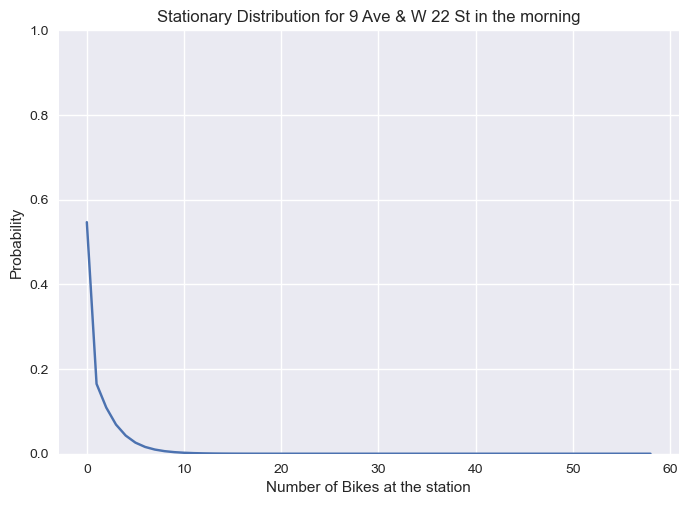

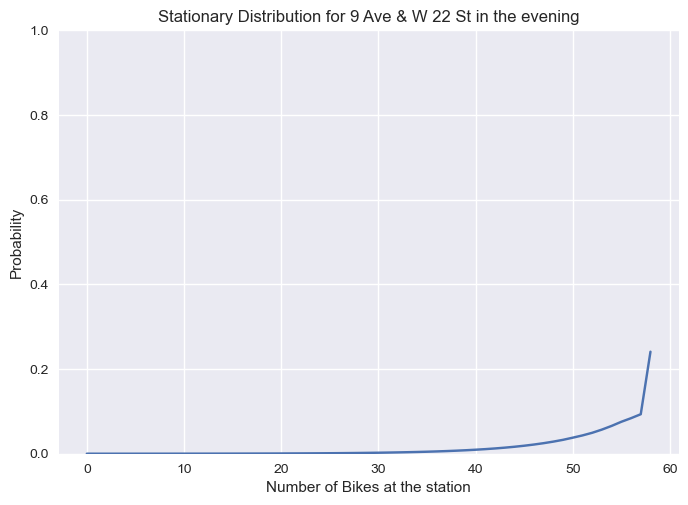

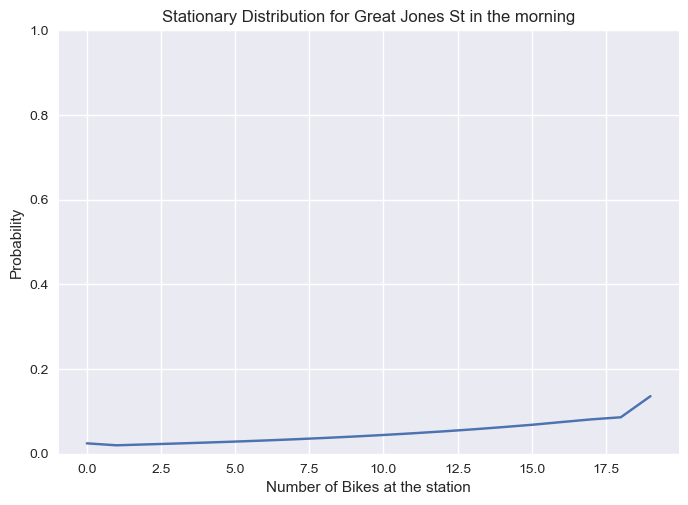

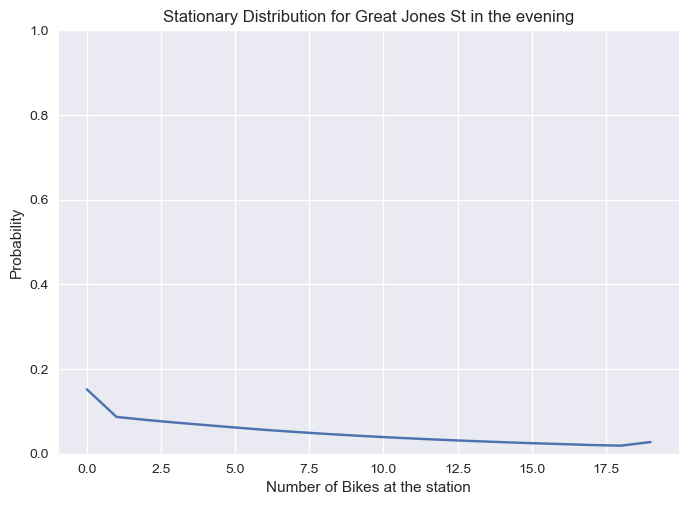

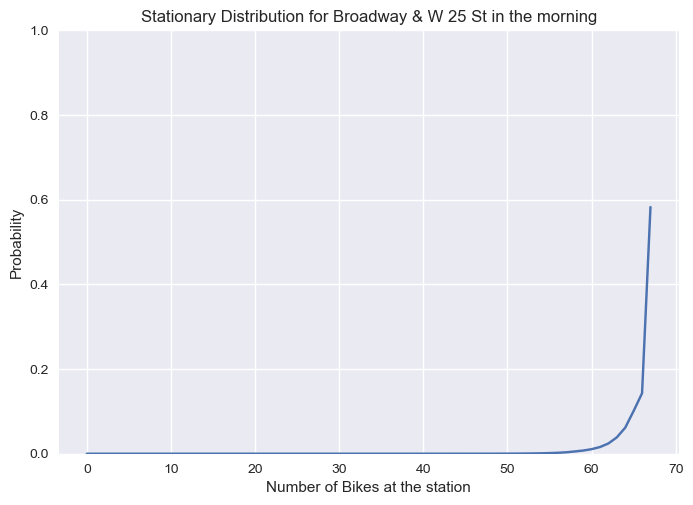

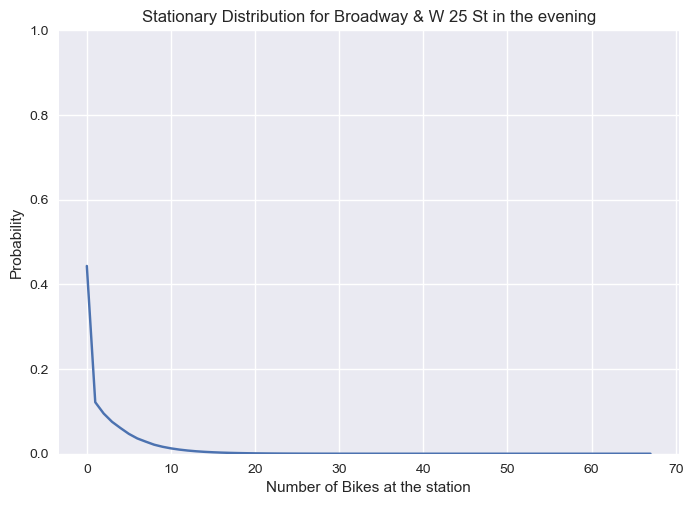

In [90]:
stations = ['9 Ave & W 22 St', 'Great Jones St', 'Broadway & W 25 St']
times = ['morning', 'evening']
plt.style.use('seaborn')

for station in stations:
    for time in times:
    
        flow, probability, transition_matrix, stationary_distribution = get_all(station, time)

        y = stationary_distribution

        plt.plot(stationary_distribution)
        plt.ylim(0, 1)
        plt.title('Stationary Distribution for ' + str(station) + ' in the ' + str(time))
        plt.xlabel('Number of Bikes at the station')
        plt.ylabel('Probability')
        plt.show()

In [ ]:
stationary_distribution

W chamber
21 6
broadway 58

In [100]:
flow, probability, trans_matrix, stat_dist = get_all("W 21 St & 6 Ave","morning", n=74)

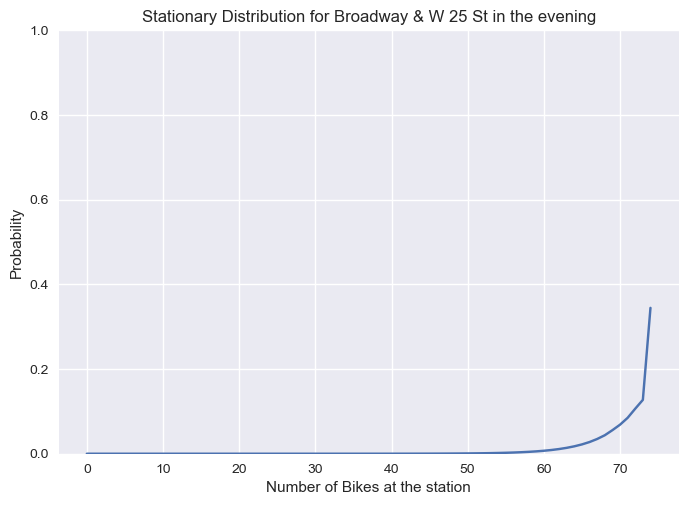

In [102]:
plt.plot(stat_dist)
plt.ylim(0, 1)
plt.title('Stationary Distribution for ' + str(station) + ' in the ' + str(time))
plt.xlabel('Number of Bikes at the station')
plt.ylabel('Probability')
plt.show()